# Boundary Equilibrimum infoGANs for Fault Detection example

## 초기 설정들

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="1"


import pickle
import gzip

file_dir = 'anoGANs_MNIST_data/'

with gzip.open(file_dir + 'test_normal_data.pickle.gzip','rb') as f :
    test_normal_data = pickle.load(f)
    print('test_normal_data : ' ,test_normal_data.shape)

with gzip.open(file_dir + 'test_anomalous_data.pickle.gzip','rb') as f :
    test_anomalous_data = pickle.load(f)
    print('test_anomalous_data : ',test_anomalous_data.shape)
    
with gzip.open(file_dir + 'train_normal_data.pickle.gzip','rb') as f :
    train_normal_data = pickle.load(f)
    print('train_normal_data : ', train_normal_data.shape)
    
with gzip.open(file_dir + 'train_anomalous_data.pickle.gzip','rb') as f :
    train_anomalous_data = pickle.load(f)
    print('train_anomalous_data : ',train_anomalous_data.shape )

def idx_shuffle(x) : 
    l = x.shape[0]
    idx = np.arange(l)
    np.random.shuffle(idx)
    shuffled_x = np.empty(x.shape)

    for i in range(l):
        shuffled_x[idx[i]] = x[i]
    
    return shuffled_x

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(64, 64), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None

#file_name = 'ex_BE_DCGANs_for_FD_v2'
file_name = 'test3_BE_DCGANs_for_FD_v2'


test_normal_data :  (5139, 64, 64, 1)
test_anomalous_data :  (4861, 64, 64, 1)
train_normal_data :  (28038, 64, 64, 1)
train_anomalous_data :  (26962, 64, 64, 1)


## network load

In [2]:
if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")
k = sess.graph.get_tensor_by_name("k:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

G_sample = sess.graph.get_tensor_by_name("G_sample:0")
E_z = sess.graph.get_tensor_by_name("E_z:0")



re_image = sess.graph.get_tensor_by_name("re_image:0")
re_z = sess.graph.get_tensor_by_name("re_z:0")


re_image_loss = sess.graph.get_tensor_by_name("re_image_loss:0")

E_loss = sess.graph.get_tensor_by_name("E_loss:0")

D_real = sess.graph.get_tensor_by_name('D_real:0')                       # D(x)
D_fake = sess.graph.get_tensor_by_name('D_fake:0')         # D(G(z))



D_enc = sess.graph.get_tensor_by_name("D_enc_1:0")

D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")


D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")
E_optim = sess.graph.get_operation_by_name("E_optim")
E_AE_optim = sess.graph.get_operation_by_name("E_AE_optim")




INFO:tensorflow:Restoring parameters from test3_BE_DCGANs_for_FD_v2/para.cktp


In [3]:
train_epoch = 15
batch_size = 100
z_size = 100
lam = 0.001
gamma = 0.5
k_curr = 0.0
c_size = 10


file_name1 = 'test3_BE_DCGANs_for_FD_v2'


if not os.path.isdir(file_name1) :
    os.mkdir(file_name1)

In [ ]:
np.random.seed(int(time.time()))


test_z = np.random.uniform(-1,1,size=(16,1,1,z_size))
mnist_4by4_save(np.reshape(test_normal_data[0:16],(-1,64,64,1)),file_name1 + '/normal.png')    
mnist_4by4_save(np.reshape(test_anomalous_data[0:16],(-1,64,64,1)),file_name1 + '/anomalous.png')    

E_error = []
start = time.time()
for epoch in range(train_epoch) :

    np.random.seed(int(time.time()))
    train_normal_data = idx_shuffle(train_normal_data) 

    for iteration in range(train_normal_data.shape[0] // batch_size) : 


        train_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
        u_ = np.reshape(train_images,(-1,64,64,1)) 
        z_ = np.random.uniform(-1,1,size=(batch_size,1,1,z_size))
        
        _  = sess.run([E_optim], {u : u_, z : z_,isTrain : True})
        
        _ , E_e = sess.run([E_AE_optim, re_image_loss], {u : u_, z : z_,isTrain : True})
        E_error.append(E_e)
        
            


    r = sess.run([re_image],feed_dict={u : test_normal_data[0:16],isTrain : False})        
    mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name1 + '/normal_{}.png'.format(str(epoch).zfill(3)))

    r = sess.run([re_image],feed_dict={u : test_anomalous_data[0:16],isTrain : False})        
    mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name1 + '/anomlous_{}.png'.format(str(epoch).zfill(3)))

    print("E_e : %.6f"%(np.mean(E_error)))
    E_error = []

saver = tf.train.Saver()
saver.save(sess,file_name1 + '/para.cktp')

end = time.time()-start

print("total time : ",end)

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
feature = []
cosine = []
res_mse = []
res_cos = []

sign_error = []


for iteration in range(test_normal_data.shape[0] // batch_size) : 
    test_images = test_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    im_re, im_z= sess.run([re_image, E_z],{u : u_,isTrain : False})
    im_re_enc= sess.run([D_enc],{u : im_re,z : im_z,isTrain : False})
    
  
    for i in range(batch_size) :
        
        
        residual_e = np.mean(np.sqrt((np.reshape(u_[i],(1,64*64))-np.reshape(im_re[i],(1,64*64)))**2))
        residual_cosine = cosine_similarity(np.reshape(u_[i],(1,64*64)),np.reshape(im_re[i],(1,64*64)))
        
        
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[0][i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[0][i],(-1,100)))
        
        sign_e = np.mean(np.abs(np.sign(im_enc)-np.sign(im_re_enc)))
        
        sign_error.append(sign_e)
        
        
        feature.append(feature_e)
        cosine.append(feature_cosine)
        res_mse.append(residual_e)
        res_cos.append(residual_cosine )

    

In [5]:
afeature = []
acosine = []
ares_mse = []
ares_cos = []
asign_error = []
for iteration in range(test_anomalous_data.shape[0] // batch_size) : 
    test_images = test_anomalous_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    
    im_re, im_z= sess.run([re_image, E_z],{u : u_,isTrain : False})
    im_re_enc= sess.run([D_enc],{u : im_re,z : im_z,isTrain : False})
    
    
    for i in range(batch_size) :
        
        residual_e = np.mean(np.sqrt((np.reshape(u_[i],(1,64*64))-np.reshape(im_re[i],(1,64*64)))**2))
        residual_cosine = cosine_similarity(np.reshape(u_[i],(1,64*64)),np.reshape(im_re[i],(1,64*64)))
        
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[0][i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[0][i],(-1,100)))
        
        sign_e = np.mean(np.abs(np.sign(im_enc)-np.sign(im_re_enc)))
        
        asign_error.append(sign_e)
        
        
        afeature.append(feature_e)
        acosine.append(feature_cosine)
        ares_mse.append(residual_e)
        ares_cos.append(residual_cosine )
    






In [6]:
train_feature = []
train_cosine = []
train_res_mse = []
train_res_cos = []
train_sign_error = []

for iteration in range(train_normal_data.shape[0] // batch_size) : 
    test_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    im_re, im_z= sess.run([re_image, E_z],{u : u_,isTrain : False})
    im_re_enc= sess.run([D_enc],{u : im_re,z : im_z,isTrain : False})
    
  
    for i in range(batch_size) :
        
        residual_e = np.mean(np.sqrt((np.reshape(u_[i],(1,64*64))-np.reshape(im_re[i],(1,64*64)))**2))
        residual_cosine = cosine_similarity(np.reshape(u_[i],(1,64*64)),np.reshape(im_re[i],(1,64*64)))
        
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[0][i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[0][i],(-1,100)))
        
        sign_e = np.mean(np.abs(np.sign(im_enc)-np.sign(im_re_enc)))
        
        train_sign_error.append(sign_e)
        
        
        train_feature.append(feature_e)
        train_cosine.append(feature_cosine)
        train_res_mse.append(residual_e)
        train_res_cos.append(residual_cosine )
            
        
        

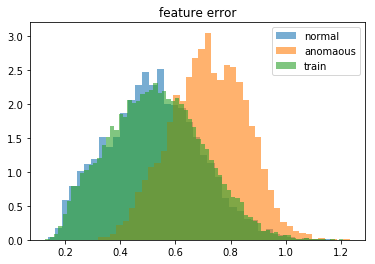

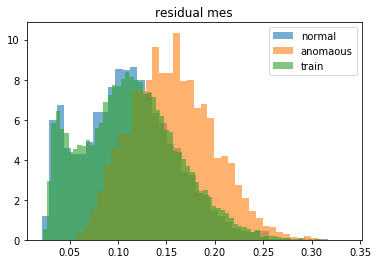

In [7]:

import scikitplot as skplt
import matplotlib.pyplot as plt


plt.hist(np.reshape(feature,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("feature error")

plt.hist(np.reshape(afeature,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_feature,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()    



plt.hist(np.reshape(res_mse,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("residual mes")



plt.hist(np.reshape(ares_mse,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_res_mse,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()    









0.819245465686


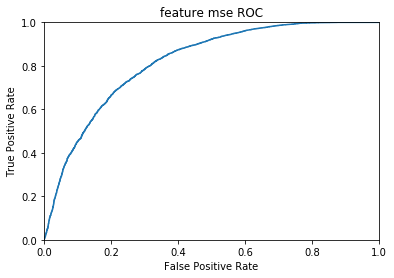

0.759074877451


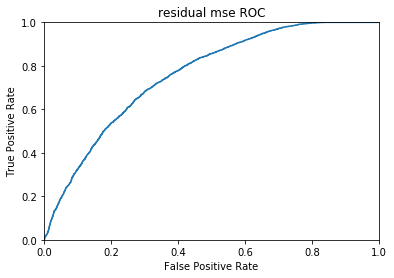

In [8]:

label_normal = np.zeros(np.array(feature).shape[0])
label_anomalous = np.ones(np.array(afeature).shape[0])

test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(feature,-1), np.reshape(afeature,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('feature mse ROC')
plt.show()
                      


label_normal = np.zeros(np.array(res_mse).shape[0])
label_anomalous = np.ones(np.array(ares_mse).shape[0])



test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(res_mse,-1), np.reshape(ares_mse,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('residual mse ROC')
plt.show()                      

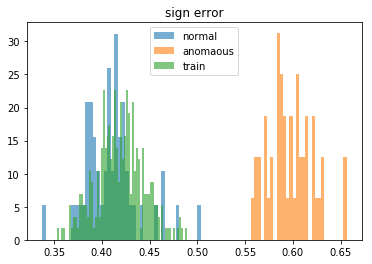

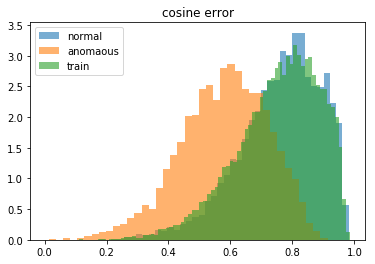

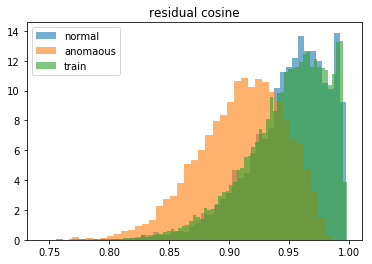

In [9]:
plt.hist(np.reshape(sign_error,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("sign error")

plt.hist(np.reshape(asign_error,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_sign_error,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()  







plt.hist(np.reshape(cosine,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("cosine error")

plt.hist(np.reshape(acosine,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_cosine,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()  


plt.hist(np.reshape(res_cos,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("residual cosine")



plt.hist(np.reshape(ares_cos,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_res_cos,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()    






1.0


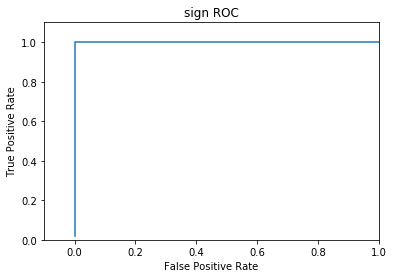

0.83219501634


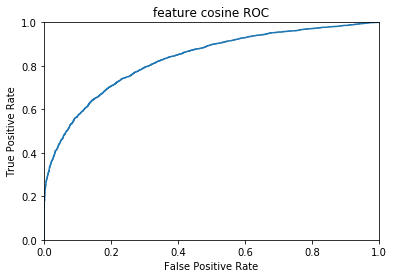

0.796507598039


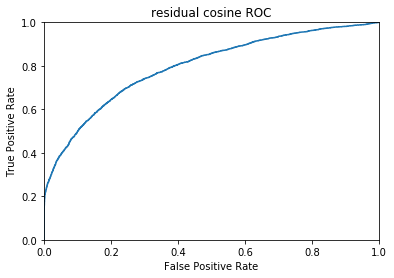

In [10]:
label_normal = np.zeros(np.array(sign_error).shape[0])
label_anomalous = np.ones(np.array(asign_error).shape[0])



test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(sign_error,-1), np.reshape(asign_error,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('sign ROC')
plt.show()    
                    
label_normal = np.ones(np.array(cosine).shape[0])
label_anomalous = np.zeros(np.array(acosine).shape[0])

test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(cosine,-1), np.reshape(acosine,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('feature cosine ROC')
plt.show()       



label_normal = np.ones(np.array(res_cos).shape[0])
label_anomalous = np.zeros(np.array(ares_cos).shape[0])

test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(res_cos,-1), np.reshape(ares_cos,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('residual cosine ROC')
plt.show()





In [ ]:


im =  test_anomalous_data[111]      
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
im_enc= sess.run([D_enc],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})




im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})
Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : np.reshape(im_re,(1,64, 64,1)),z : im_z, c : im_c,isTrain : False})

plt.imshow(np.reshape(im_re,(64, 64)), cmap='Greys_r')
plt.show()

print(im_c,Q_c)

residual_e = np.mean(np.sqrt((np.reshape(im,(1,64*64))-np.reshape(im_re,(1,64*64)))**2))
residual_cosine = cosine_similarity(np.reshape(im,(1,64*64)),np.reshape(im_re,(1,64*64)))
feature_e = np.mean(np.sqrt((np.reshape(im_enc,(1,100))-np.reshape(im_re_enc,(1,100)))**2))
feature_cosine = cosine_similarity(np.reshape(im_enc,(1,100)),np.reshape(im_re_enc,(1,100)))

print(residual_e, feature_e, residual_cosine ,feature_cosine)

In [ ]:
im_enc

In [ ]:
im_re_enc

In [ ]:
im =  test_normal_data[11]      
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')

plt.show()
im_enc= sess.run([D_enc],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})




im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})
Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : np.reshape(im_re,(1,64, 64,1)),z : im_z, c : im_c,isTrain : False})

plt.imshow(np.reshape(im_re,(64, 64)), cmap='Greys_r')
plt.show()

print(im_c,Q_c)

residual_e = np.mean(np.sqrt((np.reshape(im,(1,64*64))-np.reshape(im_re,(1,64*64)))**2))
residual_cosine = cosine_similarity(np.reshape(im,(1,64*64)),np.reshape(im_re,(1,64*64)))
feature_e = np.mean(np.sqrt((np.reshape(im_enc,(1,100))-np.reshape(im_re_enc,(1,100)))**2))
feature_cosine = cosine_similarity(np.reshape(im_enc,(1,100)),np.reshape(im_re_enc,(1,100)))

print(residual_e, feature_e, residual_cosine ,feature_cosine)
